In [15]:
import numpy as np
import pandas as pd
import math
import scipy
import sklearn as sk
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
from math import sqrt, inf
from scipy import optimize
from scipy.optimize.linesearch import scalar_search_wolfe2 
from sklearn.preprocessing import normalize
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

In [16]:
def read_df(file):
    file = load_svmlight_file(file)
    X, y = file[0].toarray(), file[1]
    y[y == -1] = 0
    y[y == 2], y[y == 4] =0,1
    X = np.reshape(X, (X.shape[0], X.shape[1]))
    return np.hstack((X, np.ones((X.shape[0],1)))), np.reshape(y, (1, X.shape[0]))

def create_df(n = 1000):
    a, b = np.random.uniform(-1, 1, size=(2,))
    X = np.random.normal(0, 1, n)
    X = np.reshape(X, (n, 1))
    y = (a*X + b > 0).astype(float)
    X = normalize(X, axis=0, norm='max')
    return np.hstack((X, np.ones((n, 1)))), np.reshape(y, (1, n))

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def func(w, X, y):
    sigm = sigmoid(X@w)
    return (-y@np.log(sigm) - (1 - y)@np.log(1 - sigm))/X.shape[0]

def gradient(w, X, y):
    return X.T@(sigmoid(X@w) - y.T)/X.shape[0]

def hessian(w, X, y):
    sigm = sigmoid(X@w)
    return X.T@(sigm*(1-sigm)*X)/X.shape[0]

def oracle_zero_order(w, X, y):
    return func(w, X, y)

def oracle_fisrt_order(w, X, y):
    return func(w, X, y), gradient(w, X, y)

def oracle_second_order(w, X, y):
    return func(w, X, y), gradient(w, X, y), hessian(w, X, y)

In [17]:
def GoldenSectionSearch(f, a, b, eps=1e-7):
    phi = (sqrt(5) + 1) / 2
    x_l = b - (b - a) / phi
    x_r = a + (b - a) / phi
    while abs(x_l - x_r) > eps:
        if f(x_l) < f(x_r):
            b = x_r
        else:
            a = x_l     
        x_l = b - (b - a) / phi
        x_r = a + (b - a) / phi
    return (b + a) / 2

In [18]:
def gss(func, grad):
    a, b =0, 1
    return GoldenSectionSearch(func, a, b)

In [19]:
def newton_descent(w, X, y, line_search, method = "gradient", eps=1e-6, max_iter=1000):
    X = normalize(X, axis=0, norm='max')
    r_k_list = []
    time_list = []
    func_k = []
    
    i, t_0 = 0, datetime.now() 
    grad_0 = gradient(w, X, y)
    
    while True:
        _, grad_k, hessian_k = oracle_second_order(w, X, y)
        
        r_k = np.linalg.norm(grad_k)**2/np.linalg.norm(grad_0)**2
        
        if r_k < eps or i >= max_iter:
            break

        u, g, v = np.linalg.svd(hessian_k)
        g[g <= 0.001] = 0.001
        hessian_k = u@np.diag(g)@v
        grad_k = np.linalg.inv(hessian_k) @ grad_k
            
        alpha = line_search(lambda s: func(w-s*grad_k, X, y),
                            lambda s: gradient(w-s*grad_k, X, y))
            
        w -= alpha*grad_k
        r_k_list.append(r_k)
        time_list.append((datetime.now()-t_0).total_seconds())
        func_k.append(func(w, X, y)[0][0])
        i+=1
    return i, func_k, r_k_list, time_list

In [129]:
def conjugate_gradient(grad, w, mu):
    d_0 = -grad
    z_0 = np.zeros(grad.shape)
    g_0 = grad
    for i in range(len(grad)):
        Hd = (oracle_fisrt_order(w+mu*d_0, X, y)[1]-oracle_fisrt_order(w-mu*d_0, X, y)[1])/(2*mu)
        alpha = g_0.T@g_0 /(d_0.T@Hd)
        z = z_0+alpha*d_0
        g = g_0+alpha*Hd
        if np.linalg.norm(g) <= mu:
            return z
        d = -g+(g.T@g)*d_0/(g_0.T@g_0)
        d_0, z_0, g_0 = d, z, g
    return -grad

In [88]:
def choose_policy(grad, policy):
    # 'const', 'sqrtGradNorm', 'gradNorm'
    if policy is 'const':
        teta_k = 1e-2
    if policy is 'sqrtGradNorm':
        teta_k = min(0.5, np.linalg.norm(grad)**0.5)
    if policy is 'gradNorm':
        teta_k = min(0.5, np.linalg.norm(grad))
    return teta_k*np.linalg.norm(grad)

In [123]:
def free_newton(w, X, y, line_search, method = "free_newton", policy ='const', eps=1e-7, max_iter=3000):
    
    r_k_list = []
    time_list = []
    func_k = []
    
    i, t_0 = 0, datetime.now() 
    grad_0 = oracle_fisrt_order(w, X, y)[1]
    
    while True:
        grad_k = oracle_fisrt_order(w, X, y)[1]
        r_k = np.linalg.norm(grad_k)**2/np.linalg.norm(grad_0)**2
        if r_k < eps or i >= max_iter:
            break
        
        mu = choose_policy(grad_k, policy)
            
        d_k = conjugate_gradient(grad_k, w, mu)
        alpha_k = line_search(lambda s: func(w, X, y),
                            lambda s: gradient(w, X, y))
        w += alpha_k*d_k
        r_k_list.append(r_k)
        time_list.append((datetime.now()-t_0).total_seconds())
        func_k.append(func(w, X, y)[0][0])
        i+=1
 
    return i, func_k, r_k_list, time_list

In [100]:
def plot_graphics(X, y, policy, fs = 18):

    line_search = [gss]
    l_s_dict = {0: "Метод золотого сечения"}

    all_iters, all_func_k, all_r_k_list, all_time_list = [],[],[],[]
    for line_s in line_search:
        w_0 = np.random.normal(scale=np.sqrt(1.0/(X.shape[1]+2)), size = (X.shape[1],1))
        iters, func_k, r_k_list, time_list = free_newton(w_0, X, y, line_s, policy)
        all_iters.append(iters)
        all_func_k.append(func_k)
        all_r_k_list.append(r_k_list)
        all_time_list.append(time_list)
    
    plt.figure(figsize = (12,4))
    for i, r_k_list in enumerate(all_r_k_list): 
        plt.plot(np.arange(all_iters[i]),[np.log(x) for x in r_k_list], label = l_s_dict[i])
        plt.xlabel("Number of itertions", fontsize=fs)
        plt.ylabel("$log(|\\nabla F(w_k)|^2/|\\nabla F(w_0)|^2)$", fontsize=fs)
        plt.title("$|\\nabla F(w_k)|^2/|\\nabla F(w_0)|^2$ and number of itertions ", fontsize=fs)
        plt.legend()

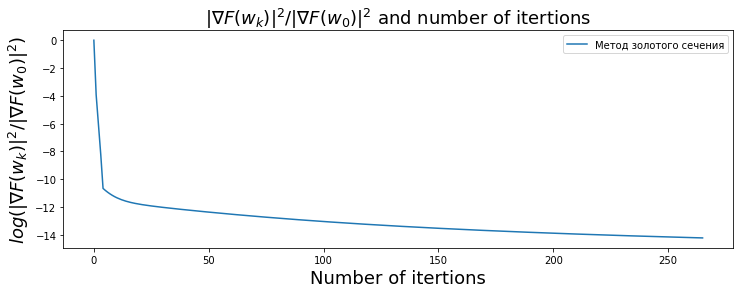

In [130]:
X, y = read_df("breast-cancer_scale.txt")
plot_graphics(X, y, policy = "const")

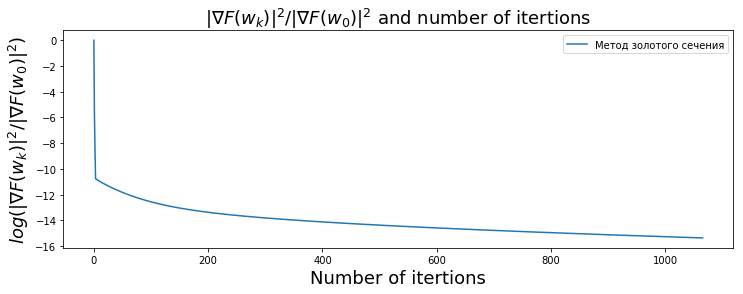

In [131]:
plot_graphics(X, y, policy = 'sqrtGradNorm')
#'const', 'sqrtGradNorm', 'gradNorm'

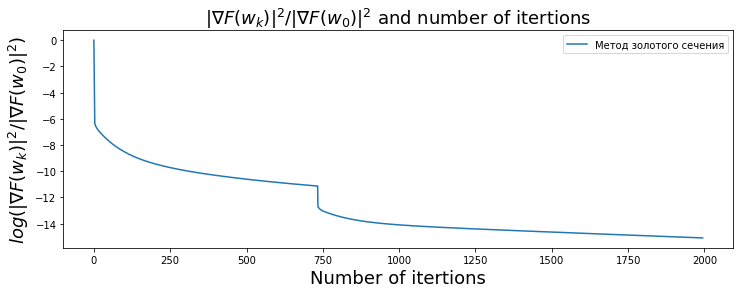

In [132]:
plot_graphics(X, y, policy = 'gradNorm')

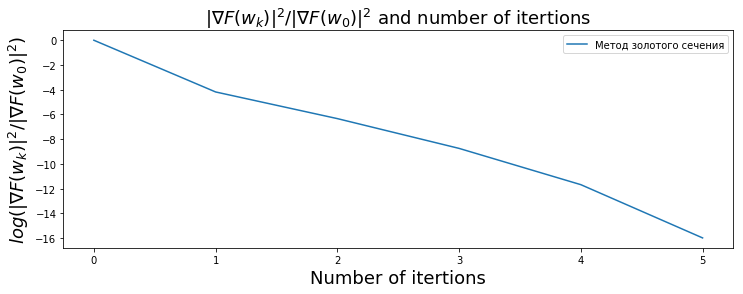

In [133]:
X, y = read_df("a1a.t")
plot_graphics(X, y, policy = "const")

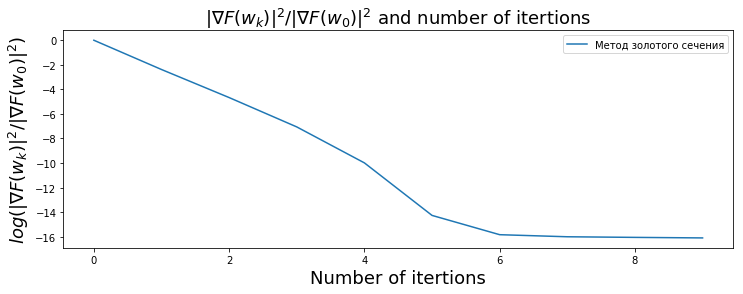

In [134]:
X, y = read_df("a1a.t")
plot_graphics(X, y, policy = "gradNorm")

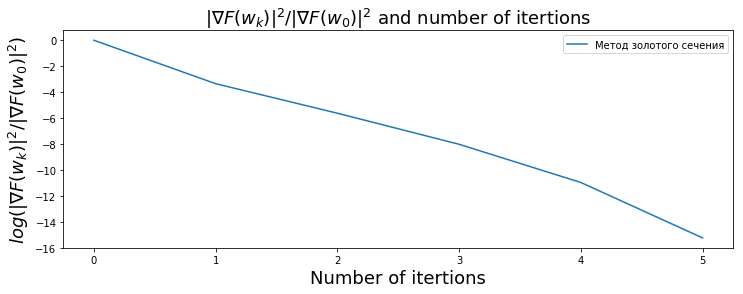

In [135]:
X, y = read_df("a1a.t")
plot_graphics(X, y, policy = "sqrtGradNorm")